# Credit Default Prediction

## Dataset

**Data Set Information:** The training data contains 22500 observations with the predictor variables as well as the response variable. The test set contains 7500 observations with the response variable removed.

**Task:** Predict the response variable (default status) for the test data.

**Variable descriptions:** This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 

This study reviewed the literature and used the following 23 variables as explanatory variables: 
- **X1:** Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- **X2:** Gender (1 = male; 2 = female). 
- **X3:** Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- **X4:** Marital status (1 = married; 2 = single; 3 = others). 
- **X5:** Age (year). 
- **X6 - X11:** History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
- **X6** = the repayment status in September, 2005; 
- **X7** = the repayment status in August, 2005; 
- **X11** = the repayment status in April, 2005. The measurement scale for the repayment status is: 
 - -1 = pay duly; 
 - 1 = payment delay for one month; 
 - 2 = payment delay for two months;  
 - 8 = payment delay for eight months; 
 - 9 = payment delay for nine months and above. 
 - -2 = indicates no consumption in the month, and a value of 
 - 0 = indicates the use of revolving credit (equivalent to prepayment)
- **X12-X17:** Amount of bill statement (NT dollar). 
- **X12** = amount of bill statement in September, 2005; 
- **X13** = amount of bill statement in August, 2005;  
- **X17** = amount of bill statement in April, 2005. 
- **X18-X23:** Amount of previous payment (NT dollar). 
- **X18** = amount paid in September, 2005; 
- **X19** = amount paid in August, 2005; 
- **X23** = amount paid in April, 2005. 

# Step 1: Data Import

In [43]:
%%time

# Import the required Python Packages
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from io import StringIO

# Import the AWS & Sagemaker Packages
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer, json_deserializer

warnings.filterwarnings('ignore') # to supress seaborn warnings
pd.options.display.max_columns = None

CPU times: user 76 µs, sys: 6 µs, total: 82 µs
Wall time: 86.8 µs


### a) Get Role, Region, Session

In [30]:
role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()

print("Role : ", role)
print("Region : ", region)

Role :  arn:aws:iam::789247493478:role/SageMakerFullAcess
Region :  us-east-1


### b) Define S3 Bucket & store raw files 

In [51]:
bucket='g-demo' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker'

# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
s3= boto3.Session(region_name=region).resource('s3')

def upload_to_s3(fobj,channel,filename):
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    s3.Bucket(bucket).Object(key).put(Body=fobj)
    
upload_to_s3(open('credit_card_default_TRAIN.csv','rb'),'input/train','credit_card_default_TRAIN.csv')
upload_to_s3(open('credit_card_default_TEST.csv','rb'),'input/test','credit_card_default_TEST.csv')

Writing to s3://g-demo/sagemaker/input/train/credit_card_default_TRAIN.csv
Writing to s3://g-demo/sagemaker/input/test/credit_card_default_TEST.csv


# Step 2: Data Preprocessing

### a) Read the data and normalize it 

In [52]:
# Read the train & test data into DataFrames.
train = pd.read_csv("credit_card_default_TRAIN.csv",index_col=0)
test = pd.read_csv("credit_card_default_TEST.csv",index_col=0)

# Fix Header of the data, row 0 serves as more sensible header names
def fix_header(data):
    new_header = data.iloc[0]    # take the first row for the header
    data = data[1:]              # take the data without the header row
    data.columns = new_header    # set the header row as the df header
    data.rename(columns={'default payment next month':'DEFAULTER'}, inplace=True) # change column name
    return data

train = fix_header(train)
test = fix_header(test)

**Check for null values in the datasets.**

In [53]:
train.isnull().values.any(),test.isnull().values.any()

(False, False)

Both train and test datasets do not have null values

In [54]:
train.describe()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULTER
count,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500
unique,77,2,7,4,55,11,11,11,11,10,10,17712,17398,17152,16769,16359,15972,6592,6476,6050,5732,5674,5684,2
top,50000,2,2,2,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,2630,13729,10634,12219,1249,11069,11849,11876,12556,12759,12128,1478,1875,2148,2356,2635,3034,3975,4098,4548,4873,5058,5485,17412


From above description of train data, we found that
  - EDUCATION has 7 unique values instead of 4 (1 = graduate school; 2 = university; 3 = high school; 4 = others) 
  - MARRIAGE has 4 unique values instead of 3 (1 = married; 2 = single; 3 = others)

In [36]:
train.EDUCATION.value_counts()

2    10634
1     7982
3     3581
5      184
4       76
6       33
0       10
Name: EDUCATION, dtype: int64

**According to description we should have values 1,2,3,4 thus we will change 5,6,0 to 4 i.e. others**

In [55]:
train.EDUCATION[train.EDUCATION=='0']='4'
train.EDUCATION[train.EDUCATION=='5']='4'
train.EDUCATION[train.EDUCATION=='6']='4'
train.EDUCATION.unique()

test.EDUCATION[test.EDUCATION=='0']='4'
test.EDUCATION[test.EDUCATION=='5']='4'
test.EDUCATION[test.EDUCATION=='6']='4'
test.EDUCATION.unique()

array(['2', '1', '3', '4'], dtype=object)

In [38]:
train.MARRIAGE.value_counts()

2    12219
1     9990
3      255
0       36
Name: MARRIAGE, dtype: int64

In [56]:
# According to description we should have values 1,2,3 thus we will change 0 to 3 i.e. others
train.MARRIAGE[train.MARRIAGE=='0']='3'
train.MARRIAGE.unique()

test.MARRIAGE[test.MARRIAGE=='0']='3'
test.MARRIAGE.unique()

array(['1', '2', '3'], dtype=object)

**Change target variable(DEFAULTER) data-type as "int" and put it at first position**

In [57]:
train.DEFAULTER = train.DEFAULTER.astype(int)
cols = list(train.columns)
cols = [cols[-1]] + cols[:-1]
train = train[cols]
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22500 entries, 1 to 22500
Data columns (total 24 columns):
DEFAULTER    22500 non-null int64
LIMIT_BAL    22500 non-null object
SEX          22500 non-null object
EDUCATION    22500 non-null object
MARRIAGE     22500 non-null object
AGE          22500 non-null object
PAY_0        22500 non-null object
PAY_2        22500 non-null object
PAY_3        22500 non-null object
PAY_4        22500 non-null object
PAY_5        22500 non-null object
PAY_6        22500 non-null object
BILL_AMT1    22500 non-null object
BILL_AMT2    22500 non-null object
BILL_AMT3    22500 non-null object
BILL_AMT4    22500 non-null object
BILL_AMT5    22500 non-null object
BILL_AMT6    22500 non-null object
PAY_AMT1     22500 non-null object
PAY_AMT2     22500 non-null object
PAY_AMT3     22500 non-null object
PAY_AMT4     22500 non-null object
PAY_AMT5     22500 non-null object
PAY_AMT6     22500 non-null object
dtypes: int64(1), object(23)
memory usage: 4.3+ MB


In [58]:
train.head()

ID,DEFAULTER,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
Variable,,,,,,,,,,,,,,,,,,,,,,,,
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
2,1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,0,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,0,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


### b) Upload the normalized data to S3

In [59]:
train_str_buffer = StringIO()
train.to_csv(train_str_buffer, index=False,header=None)

test_str_buffer = StringIO()
test.to_csv(test_str_buffer, index=False,header=None)

upload_to_s3(train_str_buffer.getvalue(),'normalized/train','credit_card_default_TRAIN.csv')
upload_to_s3(test_str_buffer.getvalue(),'normalized/test','credit_card_default_TEST.csv')

Writing to s3://g-demo/sagemaker/normalized/train/credit_card_default_TRAIN.csv
Writing to s3://g-demo/sagemaker/normalized/test/credit_card_default_TEST.csv



# Step 3: Data Visualization

### Check correlation between different features using heatmap

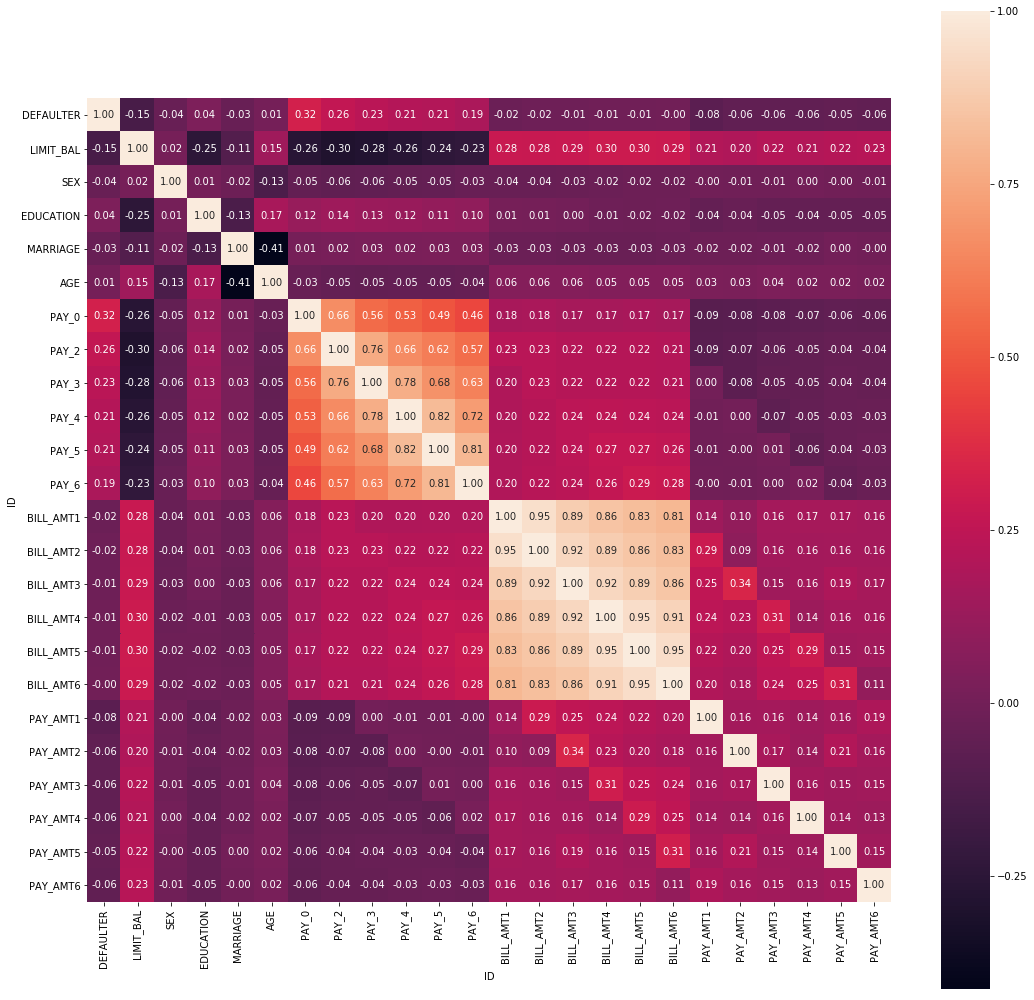

In [60]:
cor = train.astype(float).corr()
plt.show()
plt.figure(figsize=(18,18))
sns.heatmap(cor, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
            xticklabels=cor.columns.values,
            yticklabels=cor.columns.values)

**Above heatmap shows that**
- 'BILL_AMTX' are highly correlated to each other, but very less correlation to target label 'DEFAULTER'. These can be removed from normalized data when large data is there.
- Payment statuses 'PAY' show highest contribution to the defaulter label.
- We can see above that PAY_0,PAY_2...have high positive correlation to DEFAULTER
- LIMIT_BAL has pretty high negative correlation**

# Predictive Modelling (AWS Sagemaker)

# Step 4: Get the Linear-Learner Algo container

In [85]:
container = get_image_uri(boto3.Session().region_name, 'linear-learner', "latest")
print("Container : ",container)

Container :  382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest


# Step 5 : Build the model

In [97]:
s3_train_data = 's3://{}/{}/normalized/{}'.format(bucket, prefix, 'train')
print('Normalized training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}'.format(bucket, prefix)
print('Training model artifact will be uploaded to: {}'.format(output_location))

linear_learner_model = sagemaker.estimator.Estimator(container,
                                                     role, 
                                                     train_instance_count=1, 
                                                     train_instance_type='ml.m4.xlargee',
                                                     base_job_name='credit-default-prediction',
                                                     output_path=output_location,
                                                     sagemaker_session=sess
                                                    )

Normalized training data location: s3://g-demo/sagemaker/normalized/train
Training model artifact will be uploaded to: s3://g-demo/sagemaker


# Hyperparameters tuning (Optional)

- feature_dim is set to 23 excluding target label = DEFAULTER
- predictor_type is set to 'binary_classifier' since we are trying to predict whether the defaullter is 1(Yes) or 0 (No).
- mini_batch_size is set to 1000. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

In [99]:
linear_learner_model.set_hyperparameters(feature_dim=23,
                          predictor_type='binary_classifier',
                          optimizer: "adam",
                          mini_batch_size=1000)

# Step 6: Train the model

In [102]:
# Create the training job to train the model 
train_channel = sagemaker.session.s3_input(s3_train_data, content_type='text/csv')
linear_learner_model.fit({'train': train_channel},logs=False,job_name='credit-default-prediction')


2019-09-14 20:54:37 Starting - Starting the training job
2019-09-14 20:54:41 Starting - Launching requested ML instances............
2019-09-14 20:55:43 Starting - Preparing the instances for training.............
2019-09-14 20:56:54 Downloading - Downloading input data...
2019-09-14 20:57:17 Training - Downloading the training image..
2019-09-14 20:57:29 Training - Training image download completed. Training in progress...
2019-09-14 20:57:45 Uploading - Uploading generated training model
2019-09-14 20:57:51 Completed - Training job completed


# Step 7: Deploy the model for real time predictions

In [104]:
# Real time Prediction
predictor = linear_learner_model.deploy(
                                        initial_instance_count=1,
                                        instance_type='ml.m4.xlarge',
                                        endpoint_name="credit-default-prediction"
                                        )

Using already existing model: credit-default-prediction


--------------------------------------------------------------------------------------------------!

### a) Realtime predictions : predict() method

In [135]:
single_test = r'20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0'


predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

result = predictor.predict(single_test)
print('Input Record:: ',single_test)
print('Prediction :: ',result)

Input Record::  20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
Prediction ::  {'predictions': [{'score': 0.4804583191871643, 'predicted_label': 1.0}]}


### b) Real time predictions : Invoking endpoint by name

In [138]:
runtime_client = boto3.client('runtime.sagemaker')
endpoint_name = 'credit-default-prediction'

response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
                                         ContentType = 'text/csv',
                                         Body = single_test)
result = response['Body'].read().decode('utf-8')
print('Input Record:: ',single_test)
print('Prediction :: ',result)

Input Record::  20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
Prediction ::  {"predictions": [{"score": 0.4804583191871643, "predicted_label": 1.0}]}


# Step 8: Batch Transform Predictions

In [144]:
# Create a batch transform job
batch_input = 's3://{}/{}/normalized/{}'.format(bucket, prefix, 'test') # The location of the test-data dataset
batch_output = 's3://{}/{}/{}'.format(bucket, prefix, 'output') # The location of the test-data dataset

batch_transformer = linear_learner_model.transformer(instance_count=1, 
                                               instance_type='ml.m4.xlarge', 
                                               output_path=batch_output,accept='text/csv',
                                               assemble_with='Line')

batch_transformer.transform(data=batch_input, 
                      data_type='S3Prefix',
                      content_type='text/csv',                      
                      split_type='Line',
                      join_source='Input'
                      #,job_name='batch-credit-default-predictions'
                     )
batch_transformer.wait(logs=False)
print("Batch predictions generated successfully !!")

Using already existing model: credit-default-prediction


.............................................!
Batch predictions generated successfully !!


## Model Metrics

In [167]:
metrics_dataframe = linear_learner_model.training_job_analytics.dataframe()
metrics_dataframe[['metric_name','value']]

,metric_name,value
0,train:progress,45.428571
1,train:objective_loss,0.487678
2,train:recall,0.381682
3,train:precision,0.630110
4,train:objective_loss:final,0.472193
5,train:binary_f_beta,0.475398
6,train:binary_classification_accuracy,0.809511
7,train:throughput,29202.586217
